In [1]:
import numpy as np
import pandas as pd
import editdistance
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Data loading and basic data cleaning

In [39]:
registers = ['reg01', 'reg02', 'reg03', 'reg04', 'reg05', 'reg06', 'reg06bis', 'reg07']
encoding = 'utf-8'
path_segmentation = '/dhlabdata4/mion/P2PaLA/sommarioniProcessed'
path_htr = '/dhlabdata4/mion/PyLaia/egs/decipher-venice/data/sommarioni'
path_original_img = '/dhlabdata4/sommarioni'
path_test_set = '/dhlabdata4/mion/VeniceTimeMachineSommarioniHTR/Test_set/sommarioni_cleaned_gt.tsv'
output_path = "result.csv"

In [40]:
def replace_quondam(s):
    return s.replace('quondam', 'q.')

def clean_excel(excel):
    excel["denom_pezzi_di_terra"] = excel["denom_pezzi_di_terra"].apply(lambda x: str(x).replace(";", " "))
    excel["possessore"] = excel["possessore"].apply(lambda x: replace_quondam(str(x)))
    return excel.drop(columns=['Unnamed: 0'])

def clean_result_htr(result_htr):
    result_htr["cleaned"] = result_htr["cleaned"].apply(lambda x: replace_quondam(str(x)))
    result_htr = result_htr.dropna()
    result_htr = result_htr[result_htr['cleaned']!='nan']
    result_htr['id'] = result_htr["id"].apply(lambda x: str(x)+'.jpg')
    return result_htr

def clean_metadata(metadata):
    # the page name must finish with a number
    metadata['last_token'] = metadata['page_name'].str.split('_').apply(lambda x : x[-1].split('.')[0])
    metadata = metadata[metadata['last_token'].str.isnumeric()==True].drop(columns=['last_token'])
    return metadata.drop(columns=['Unnamed: 0'])

def remove_numeric_htr_result(result_htr):
    return result_htr[result_htr['cleaned'].str.isnumeric()==False]

def remove_one_letter_htr_result(result_htr):
    return result_htr[result_htr['cleaned'].str.len() > 1]

def show_sommarioni(pageID, register):
    path_original_img_reg = os.path.join(path_original_img, register)
    path_image = os.path.join(path_original_img_reg, pageID+'.jpg')
    img = mpimg.imread(path_image)
    fig= plt.figure(figsize=(20,15))
    plt.imshow(img) 
    plt.show()
    
def extract_page(index, result_htr, metadata):
    patch_id = result_htr['id'].iloc[index]
    return metadata[metadata['filename']==patch_id]['page_name'].iloc[0]

In [41]:
excel = clean_excel(pd.read_excel('sommarioni_cleaned_original.xlsx'))
result_htr = pd.DataFrame()
metadata = pd.DataFrame()
htr_metadata = pd.DataFrame()

for register in registers:
    path_htr_register = os.path.join(path_htr,register)
    path_segmentation_htr = os.path.join(path_segmentation, register)
    result_htr_reg = clean_result_htr(pd.read_csv(os.path.join(path_htr_register,'patches_'+register+'.csv')))
    
    metadata_path = os.path.join(path_segmentation_htr,'results/prod/dataframe')
    csv_files=os.listdir(metadata_path)
    metadata_reg = pd.read_csv(os.path.join(metadata_path,csv_files[0]), encoding=encoding)
    for f  in csv_files[1:]:
        metadata_reg = metadata_reg.append(pd.read_csv(os.path.join(metadata_path,f), encoding=encoding))
    metadata_reg = clean_metadata(metadata_reg)
    htr_metadata_reg = result_htr_reg.join(metadata_reg.set_index('filename'), on='id', how='inner')
    htr_metadata_reg['register'] = register
    
    result_htr = result_htr.append(result_htr_reg)
    metadata = metadata.append(metadata_reg) 
    htr_metadata = htr_metadata.append(htr_metadata_reg)
htr_metadata['collumn_number']=htr_metadata['collumn_number'].astype(int)
htr_metadata = htr_metadata.reset_index()\
                           .drop(columns=['index'])

In [42]:
htr_metadata.head()

,id,cleaned,x_min,x_max,y_min,y_max,collumn_number,patch_number,page_name,register
0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,c,3416,3481,4031,4168,7,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
1,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,2032. 33. 34. 35,1851,2466,2904,3045,4,2.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
2,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,2023 202,1855,2264,4494,4628,4,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
3,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,1,3477,3552,3719,3867,7,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
4,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,2030,1923,2084,3088,3225,4,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01


In [43]:
excel.head()

,place_acronym,numero_della_mappa,subalterno,corr_as,corr_ai,place,denom_pezzi_di_terra,possessore,qualita
0,NSM,1,NaN,ASM 2121 ASM 2122,AISM 2121 AISM 2122,SM - Parrocchia di S. Fantino,3205 3206,PAGANI - Concorso de' creditori,Casa d'affitto
1,NSM,2,1,ASM 2124,AISM 2124,SM - Parrocchia di S. Fantino,3207,TIEPOLO Gerolamo q. Almorò,Casa d'affitto
2,NSM,2,2,ASM 2124,AISM 2124,SM - Parrocchia di S. Fantino,nan,PAGANI - Concorso come sopra al N° 1 [de' cred...,Casa d'affitto
3,NSM,3,1,ASM 2123,AISM 2123,SM - Parrocchia di S. Fantino,3208,BELLI Angelo Livellario di Lorenzo Tiepolo,Bottega unica a proprio uso
4,NSM,3,2,ASM 2123,AISM 2123,SM - Parrocchia di S. Fantino,3209,TIEPOLO Lorenzo q. Almorò,Superiori d'affitto


In [ ]:
show_sommarioni('Censo-stabile_Sommarioni-napoleonici_reg-1_0200_198', 'reg01')

# Data wrangling

In [2]:
def extract_column_htr(htr_data, col_number):
    return htr_data[htr_data['collumn_number']==col_number]['cleaned']

def stats_length_column(htr_data, col_number):
    col = extract_column_htr(htr_data, col_number)
    return col.apply(lambda x : len(str(x))).describe()

def mean_length_column(htr_data, col_number):
    stats = stats_length_column(htr_data, col_number)
    if 'mean' in stats:
        return stats['mean']
    return np.NaN

def mean_length_colum_vector(htr_data):
    vector = {}
    for c in range(htr_data['collumn_number'].max()+1):
        vector[c] = mean_length_column(htr_data, c)
    return vector

def mean_length_matrix(htr_metadata):
    feature_m=[]
    for page in tqdm(sorted(htr_metadata['page_name'].unique())):    
        page_htr_metatada = htr_metadata[htr_metadata['page_name']==page]

        feature_v = mean_length_colum_vector(page_htr_metatada)
        feature_v['page_name'] = page
        feature_m.append(feature_v)

    return pd.DataFrame(feature_m).set_index('page_name')

def print_all_mean(htr_data):
    for c in range(htr_data['collumn_number'].max()+1):
        print('Mean length col', c,':',mean_length_column(htr_data, c))

def plot_pca(matrix, axe, hue=0):
    X_pca = PCA(n_components=2).fit_transform(matrix.fillna(0))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],hue=hue, legend='full', hue_order= ['Aligned','Skewed'], ax=axe)
    
def extract_vector(row):
    return np.array(row.drop('cluster')).reshape((1,-1))
def roll_left(vector, means):
    rolled = np.roll(vector, shift=-1)
    rolled[:,-1]=means[-1]
    return rolled

def roll_right(vector, means):
    rolled = np.roll(vector, shift=1)
    rolled[:,0] = means[0]
    return rolled

def compute_fixes(htr_metadata, matrix, kmeans,legend_map):
    means = mean_length_colum_vector(htr_metadata[htr_metadata['register']=='reg01'])
    means = [means[col] for col in means]
    matrix = matrix[matrix['cluster']=='Skewed'].fillna(0)
    fixes = {}
    for i, row in matrix.iterrows():
        vector = extract_vector(row)
        rolled_left = roll_left(vector, means)

        pred = kmeans.predict(rolled_left[:,:9])
        if legend_map[pred[0]]=='Aligned':
            fixes[i] = 'LEFT'
        else:
            rolled_right = roll_right(vector, means)
            pred = kmeans.predict(rolled_right[:,:9])
            if legend_map[pred[0]]=='Aligned':
                fixes[i] ='RIGHT'
            else:
                fixes[i] ='NO'
    return fixes

def apply_fixes(htr_metadata, fixes):
    for page in fixes:
        index = htr_metadata['page_name']==page
        if fixes[page] =='LEFT':
            htr_metadata.loc[index, 'collumn_number']=htr_metadata.loc[index, 'collumn_number'].apply(lambda x: x-1)
        elif fixes[page] == 'RIGHT':
            htr_metadata.loc[index, 'collumn_number']=htr_metadata.loc[index, 'collumn_number'].apply(lambda x: x-1)
    return htr_metadata

def filter_columns(htr_metadata):
    return htr_metadata[(htr_metadata['collumn_number']>=0)& (htr_metadata['collumn_number']<=8)]

def cluster_matrix(matrix):
    kmeans = KMeans(n_clusters=2).fit(matrix.fillna(0))
    aligned_cluster = np.argmax(np.bincount(kmeans.labels_))
    skewed_cluster = int(not aligned_cluster)
    legend_map = {aligned_cluster:'Aligned', skewed_cluster:'Skewed'}
    labels = list(map(lambda x:legend_map[x], kmeans.labels_))
    return labels, legend_map, kmeans

100%|██████████| 65/65 [00:01<00:00, 60.78it/s]


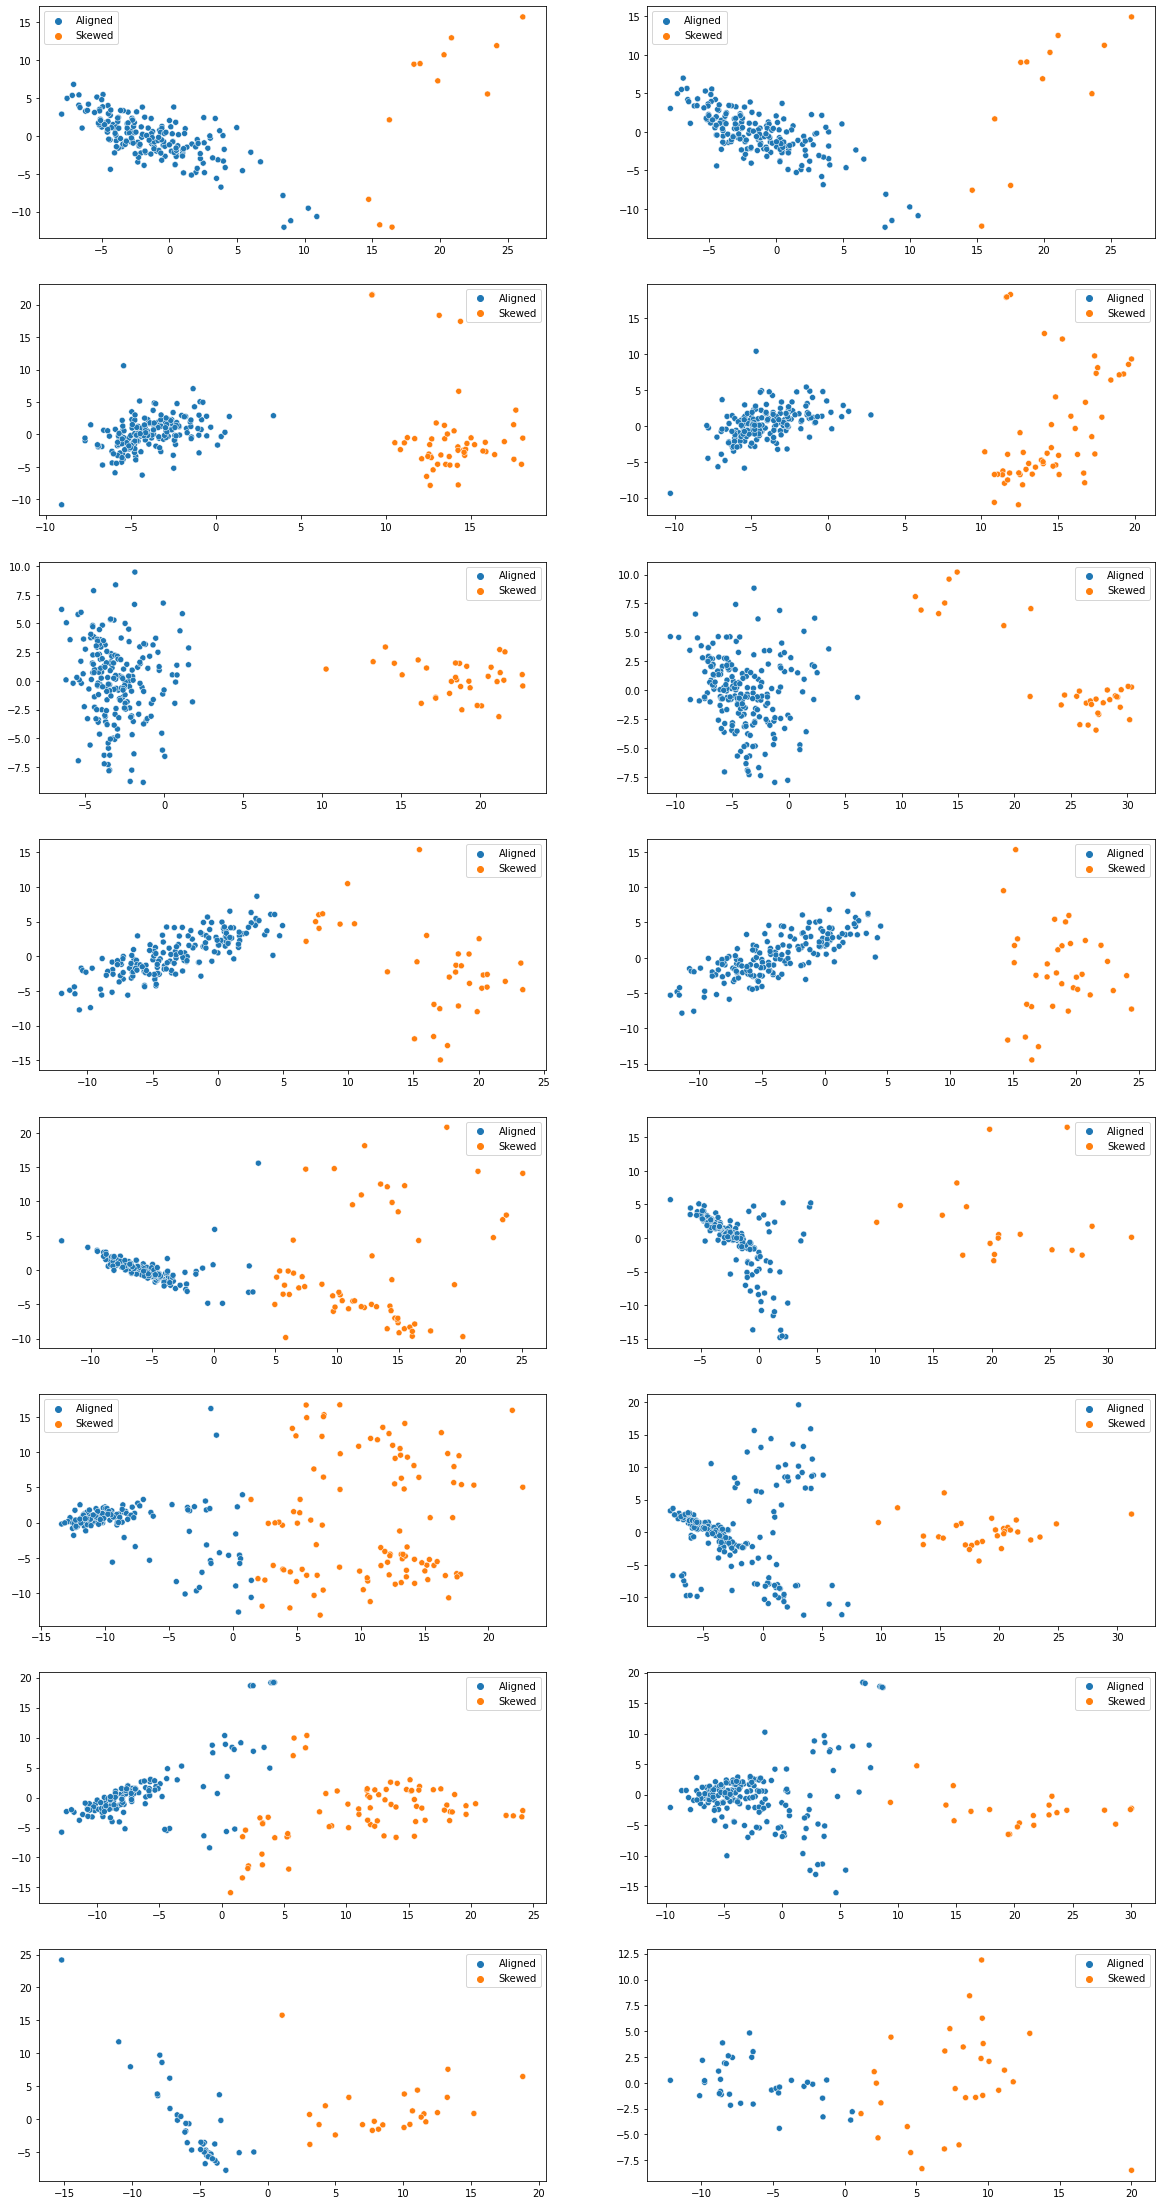

In [46]:
fig, axes = plt.subplots(8,2, figsize=(20,40), squeeze=False)
plot_line = 0
pages=[]
for i,register in enumerate(registers):
    htr_metadata = filter_columns(htr_metadata)
    matrix = mean_length_matrix(htr_metadata[htr_metadata['register']==register])
    labels, legend_map, kmeans = cluster_matrix(matrix)
    
    plot_col = 0
    plot_pca(matrix, axes[plot_line,plot_col], labels)
    
    matrix['cluster']=labels
    
    fixes = compute_fixes(htr_metadata, matrix, kmeans,legend_map)
    htr_metadata = apply_fixes(htr_metadata, fixes)
    htr_metadata = filter_columns(htr_metadata)
    
    matrix = mean_length_matrix(htr_metadata[htr_metadata['register']==register])
    labels, legend_map, kmeans = cluster_matrix(matrix)
    
    plot_col = 1
    plot_pca(matrix, axes[plot_line,plot_col], labels)
    
    matrix['cluster']=labels
    
    pages = pages + sorted(list(matrix[matrix['cluster']=='Aligned'].reset_index()['page_name']))
    plot_line+=1

# Matching

## Text Distances

In [19]:
def format_string(x):
    return x.strip().casefold()

def count_spaces(s):
    return s.strip().count(' ')

def dist_edit_distance(query, record):
    return editdistance.eval(format_string(query),format_string(record))

def dist_edit_distance_substrings(query, record):
    if len(query) >= len(record):
        return dist_edit_distance(query, record)
    
    substring_length = len(query)
    
    min_dist = np.Infinity
    for i in range(len(record)-substring_length):
        min_dist = min(min_dist, dist_edit_distance(query, record[i:i+substring_length]))
    
    return min_dist

def dist_edit_distance_substrings_threshold(query, record, threshold_q=10, threshold_r=2):
    if count_spaces(query) >  threshold_q and count_spaces(record)>threshold_r:
        return dist_edit_distance_substrings(record, query)
        
    return dist_edit_distance_substrings(query, record)

def edit_distance_search(search, df, columns):
    def search_column(search, df, column):
        return df[column].map(lambda x: dist_edit_distance_substrings_threshold(search, x))
    
    index = []
    for column in columns:
        search_res = search_column(search, df, column)
        index.append((search_res.idxmin(), search_res.min()))
    return index

def min_edit_distance_search(search, df, columns):
    search_res = edit_distance_search(search, df, columns)
    indexes, distances = list(zip(*search_res))
    min_i = np.argmin(distances)
    return indexes[min_i], df[columns[min_i]].loc[indexes[min_i]]



## Matching functions

In [25]:
def extract_possessore(htr_metadata):
    possessore = htr_metadata[htr_metadata['collumn_number']==3]
    return remove_one_letter_htr_result(remove_numeric_htr_result(possessore))

def extract_numero_della_mappa(htr_metadata):
    numero_della_mappa = pd.DataFrame(htr_metadata[htr_metadata['collumn_number']==1])
    numero_della_mappa['cleaned'] = numero_della_mappa['cleaned'].apply(lambda x : x.replace('.',''))
    return numero_della_mappa[numero_della_mappa['cleaned'].str.isnumeric()]

def next_window_page(page_name, page_index,window, pages):
    if page_index+1<len(pages) and page_name == window[1]:
        return page_index+1
    return page_index

def next_sliding_window_page(page_name, page_index,window):
    increment = window.index(page_name)
    return page_index+increment

def iiif_url(p):
    return p['scheme']+'://'+p['server']+'/'+p['prefix']+'/'+\
           p['identifier']+'/'+p['region']+'/'+p['size']+'/'+\
           p['rotation']+'/'+p['quality']+'.'+p['format'] 

def patch_to_iiif(patchID):
    def get_iif_register(register):
        return register.replace('-','').replace('0','')
    
    tokens = patchID.split('_')
    register = get_iif_register(tokens[2])
    page= tokens[3]
    
    x_min=tokens[5]
    x_max=tokens[6]
    y_min=tokens[7]
    y_max=tokens[8]
    
    w = str(int(x_max)-int(x_min))
    h = str(int(y_max)-int(y_min))
    
    iiif={}
    iiif['scheme'] = 'https'
    iiif['server'] = 'images.center'
    iiif['prefix'] = 'iiif_sommarioni'
    iiif['identifier'] = register+'-'+page
    iiif['region'] = format_iiif_region(x_min,y_min,w,h)
    iiif['size'] = 'full'
    iiif['rotation'] = '0'
    iiif['quality'] = 'default'
    iiif['format'] = 'jpg'
    
    return iiif

def patch_iiif_url(patchID):
    return iiif_url(patch_to_iiif(patchID))

def line_iiif_url(patchID):
    iiif = patch_to_iiif(patchID)
    regions = iiif['region'].split(',')
    iiif['region'] = format_iiif_region('0', regions[1], '6000', regions[3])
    
    
    return iiif_url(iiif)

def get_iif_register(register):
    return register.replace('-','').replace('0','')

def format_iiif_region(x,y,w,h):
     return x+','+y+','+w+','+h

## Matching algorithm

In [51]:
WINDOW_SIZE = 0
matching_target = pd.DataFrame(excel)

numero_della_mappa = extract_numero_della_mappa(htr_metadata_filtered)
possessore = extract_possessore(htr_metadata_filtered)

matching_numero_della_mappa = []
matching_possessore = []
matching_type = []
matching_page = []
matching_patch = []
matching_line = []

page_index = 0
for index, entry in tqdm(matching_target.iterrows()):
    search = numero_della_mappa[numero_della_mappa['cleaned'] == entry['numero_della_mappa']]
    candidates = sorted(list(search['page_name'].unique()))
    
    window = pages[page_index: page_index+WINDOW_SIZE]
    sequential_guess = True
    
    patch = ""
    line = ""
    page_name = ""
    matched_action = ""
    matched_possessore = ""
    if len(candidates) == 1 and (WINDOW_SIZE == 0 or candidates[0] in window):
        page_name = candidates[0]
        matched_action = "NUMERO_DELLA_MAPPA"
        sequential_guess = False
        patchID = search[search['page_name']==page_name]['id'].iloc[0]
        patch = patch_iiif_url(patchID)
        line = line_iiif_url(patchID)
    else:
        search_index, search_res = min_edit_distance_search(entry['possessore'], possessore, ['cleaned'])
        temp_page = possessore['page_name'].loc[search_index]
        
        if WINDOW_SIZE == 0 or temp_page in window: 
            sequential_guess = False
            page_name = temp_page
            matched_possessore = search_res
            patchID = possessore['id'].loc[search_index]

            if page_name in candidates:
                matched_action = "NUMERO_DELLA_MAPPA & POSSESSORE"
                patchID = search[search['page_name']==page_name]['id'].iloc[0]
            else:
                matched_action = "POSSESSORE"
                
            patch = patch_iiif_url(patchID)
            line = line_iiif_url(patchID)
        elif len(candidates) > 0:
            for candidate in candidates:
                if candidate in window:
                    page_name = candidate
                    matched_action = "NUMERO_DELLA_MAPPA"
                    sequential_guess = False
                    patchID = search[search['page_name']==page_name]['id'].iloc[0]
                    patch = patch_iiif_url(patchID)
                    line = line_iiif_url(patchID)
            
    
    if sequential_guess:
        page_name =pages[page_index]
        matched_action ="SEQUENTIAL_GUESS"
    

    matching_numero_della_mappa.append(candidates)
    matching_possessore.append(matched_possessore)
    matching_page.append(page_name)
    matching_type.append(matched_action)
    matching_patch.append(patch)
    matching_line.append(line)
    
    if WINDOW_SIZE != 0:
        page_index = next_sliding_window_page(page_name, page_index,window)
    
matching_target['matching_numero_della_mappa'] = matching_numero_della_mappa
matching_target['matching_possessore'] = matching_possessore
matching_target['matching_type'] = matching_type
matching_target['matching_page'] = matching_page
matching_target['matching_patch'] = matching_patch
matching_target['matching_line'] = matching_line

matching_target.to_csv(output_path)

23428it [1:38:21,  3.97it/s]


# Evaluation

In [34]:
def accuracy_matching(results, path_test_set):
    test_set = pd.read_csv(path_test_set, sep='\t', encoding=encoding)#.head(1600)
    test_set = test_set[test_set['gt_page'].isnull()==False]
    joined = test_set.join(results, rsuffix='res')[['matching_page','gt_page']]
    
    n = len(joined)
    print(n)
    match=0
    for i, pair in joined.iterrows():
        if pair['matching_page']+'.jpg' == pair['gt_page']:
            match += 1
    return match/float(n)

In [ ]:
results = pd.read_csv(output_path)
print("Accuracy : ", accuracy_matching(results, path_test_set))